In [1]:
import os
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.tree import export_graphviz
%matplotlib inline

In [2]:
train_df = pd.read_csv(os.path.join("input",'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [3]:
train_df.shape

(629145480, 2)

In [4]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


In [5]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

In [15]:
def create_features(seg_id,seg, X):
    xc = seg["acoustic_data"]

    X.loc[seg_id,"avg"] = xc.mean()
    X.loc[seg_id,"max"] = xc.max()
    X.loc[seg_id,"min"] = xc.min()
    X.loc[seg_id,"skew"] = xc.skew()
    X.loc[seg_id,"kurt"] = xc.kurt()
    X.loc[seg_id,"median"] = xc.median()
    X.loc[seg_id,"var"] = xc.var()

In [16]:
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg,train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

In [17]:
def load_test():
    signals = []
    segment_names = [file for file in os.listdir("./input") if file.startswith("seg")]
    test_df = pd.DataFrame(index=segment_names, dtype=np.float64)
    test_df.index = test_df.index.str[:-4]
    for file in tqdm_notebook(segment_names):
        seg_id = file[:-4]
        segment = pd.read_csv(os.path.join("input",file),dtype={'acoustic_data': np.int16})
        create_features(seg_id,segment,test_df)
    return test_df
test_df = load_test()

In [24]:
train_X.head()

,avg,max,min,skew,kurt,median,var
0,4.884113,104.0,-98.0,-0.024061,33.662481,5.0,26.021284
1,4.725767,181.0,-154.0,0.390561,98.758517,5.0,43.412599
2,4.906393,140.0,-106.0,0.217391,33.555211,5.0,48.544621
3,4.902240,197.0,-199.0,0.757278,116.548172,5.0,47.918309
4,4.908720,145.0,-126.0,0.064531,52.977905,5.0,53.306210


In [25]:
test_df.head()

,avg,max,min,skew,kurt,median,var
seg_00030f,4.491780,115.0,-75.0,0.327908,28.837568,4.0,23.948199
seg_0012b5,4.171153,152.0,-140.0,0.295708,56.218955,4.0,35.080027
seg_00184e,4.610260,248.0,-193.0,0.428688,162.118284,5.0,48.260671
seg_003339,4.531473,85.0,-93.0,0.061889,41.241827,5.0,16.926202
seg_0042cc,4.128340,177.0,-147.0,0.073898,79.539708,4.0,33.607106


In [26]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [52]:
tree_clf = DecisionTreeRegressor(max_depth=5)

In [53]:
features_importance = pd.DataFrame({"features":train_X.columns,
                                    "importance":np.zeros(train_X.columns.shape[0])})
predictions = pd.DataFrame({"seg_id":test_df.index,"time_to_failure":np.zeros(test_df.shape[0])})
oof = np.zeros(segments)
for train_idx,val_idx in folds.split(train_X,train_y):
    X_train,y_train = train_X.iloc[train_idx],train_y.iloc[train_idx]
    X_val,y_val = train_X.iloc[val_idx],train_y.iloc[val_idx]
    
    tree_clf.fit(X_train,y_train)
    
    oof[val_idx] = tree_clf.predict(X_val)
    
    features_importance["importance"] += tree_clf.feature_importances_
    predictions["time_to_failure"] += tree_clf.predict(test_df) 
    
    print("MAE_val = {}".format(mean_absolute_error(y_val,oof[val_idx])))

MAE_val = 2.254371455798274
MAE_val = 2.2650069605921845
MAE_val = 2.275408234449147
MAE_val = 2.2078307953820406
MAE_val = 2.306539357913222


In [57]:
mean_absolute_error(train_y,oof)

2.2618207008372058

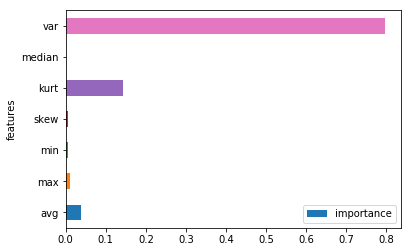

In [54]:
features_importance["importance"] = features_importance["importance"]/5
predictions["time_to_failure"] = predictions["time_to_failure"]/5
features_importance.plot(kind='barh',x="features",y="importance")

In [55]:
predictions.to_csv("submissions/submission_tree.csv",index=False)

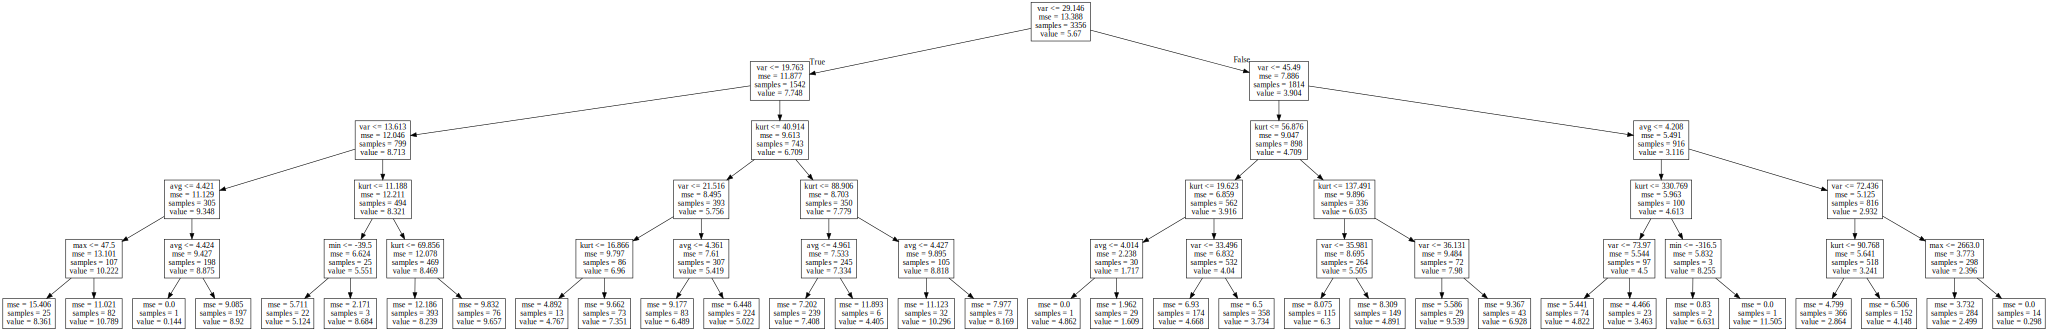

In [56]:
import graphviz
from IPython.display import display

dot_data = export_graphviz(tree_clf,out_file=None,feature_names=train_X.columns )
graph = graphviz.Source(dot_data)
display(graph)